<a href="https://colab.research.google.com/github/cesarz10/Neuro-Engineering-UGent/blob/main/Practicum_FunctionalConnectivity_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuro-engineering science
## Practical Session: Functional Connectivity
***
*prof. Pieter van Mierlo, Jolan Heyse, Gert Van Hollebeke, Emma Depuydt* <br>
*Medical Image and Signal Processing (MEDISIP)* <br>
*Ghent University Hospital, C. Heymanslaan 10, 9000 Gent, Belgium*

<font color=blue>Student name(s) and ID(s): </font>

### Practical info
This practical session is about functional brain connectivity. Background documentation about this subject can be found in the course notes. The necessary files for the exercises can be downloaded from Ufora. We expect you to hand in the notebook with your code together with the figures via Ufora. The deadline for submission is ***7/12/2022 at 11.59pm***.

### Goal of today
The goal of this practical session is to gain better understanding on how functional connectivity measures are computed, and how they can be applied to analyse brain signals. At the end of the excercise, you will have gained hands-on experience in using these techniques to identify the onset zone of an epileptic seizure in real patient data.

## Clinical context
#### Epilepsy
Epilepsy is a neurological disorder characterised by recurrent seizures. Epileptic seizures can be described as periods of abnormal brain activity that cause unusual behavior, sensations, and sometimes loss of awareness.

The physical presentation of the seizures can vary greatly and patients may experience a set of symptoms. Some people with epilepsy simply stare blankly for a few seconds during a seizure, while others repeatedly twitch their arms or legs. Having a single seizure doesn't mean you have epilepsy. At least two unprovoked seizures are generally required for an epilepsy diagnosis.

#### Electroencephalogram (EEG)
Electroencephalography (EEG) is one of the essential tools in neurology and allows to measure electrical activity in your brain by placing electrodes on top of the scalp. Brain cells communicate via electrical impulses and are active all the time, even when you're asleep. This activity shows up as wavy lines on an EEG recording. EEG is one of the main diagnostic tests for epilepsy, but can also play a role in diagnosing and evaluating other brain disorders.

#### EEG in epilepsy
EEG is one of the cornerstone tests for diagnosing epilepsy. Epileptic seizures involve abnormal, hypersynchronous activity in the brain that create a distinct pattern in the EEG signals. However, even in the absence of a seizure epilepsy patients often have small, transient episodes of abnormal activity called 'spikes'. Presence of these epileptic spikes in the EEG signal is one of the hallmarks for diagnosing epilepsy.

Identifying the brain region where epileptic activity originates is a non-trivial task and requires a lot of expertise of the neurologist. Functional connectivity can assist the medical expert, by providing an estimation of the brain network during the epileptic seizure. Based on the information flows the source of the epileptic network can be identified. In this practical session you will compute several connectivity measures and try to identify the seizure onset zone based on an intracranial EEG recording of a real patient.

***
## Part 1/2: Simple brain network
A patient has 3 depth electrodes implanted in the brain. Each depth electrode has 1 contact. The signals recorded from these 3 brain regions are given in sig_ex1.mat with a sampling rate (fs) of 200 Hz and length equal to 5s. You need to investigate how the regions communicate with each other by studying the functional connectivity between the signals.

<img src='https://drive.google.com/uc?export=view&id=1D4zMx7g6dRaTyr0l0_e3LDNy--i2RTV3' style="width: 350px;">


Let's load the necessary modules and take a look at the signals.

In [4]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
googledrive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%%capture
# Download a file based on its file ID.
file_id = '1UjR4Vf1IFQafpZGfeSuVmVknC8ZWw1W4'

download = googledrive.CreateFile({'id': file_id})
download.GetContentFile('PracticalSession_EEGconnectivity.zip')
!unzip 'PracticalSession_EEGconnectivity.zip'

In [7]:
%%capture 
!pip install mne
!pip install connectivipy

In [8]:
%matplotlib inline

import mne
import numpy as np
import matplotlib.pyplot as plt
import connectivipy as cp
from scipy.signal import coherence

def plot_EEG(t, sig, labels=None):
    n_sig = np.shape(sig)[1]
    offset = np.linspace(3*n_sig, -3*n_sig, num=n_sig)
    if labels is None:
        labels = [f"sig {i}" for i in range (1, n_sig+1)]
        
    for i in range(n_sig):
        x = sig[:,i]
        # Normalize array
        x -= np.mean(x)
        x /= np.std(x)
        # Plot array
        plt.plot(t, sig[:,i]+offset[i], 'k', label=labels[i])
        
    plt.yticks(offset, labels)
    plt.xlabel("Time (s)")
    plt.show()


[0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055
 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115
 0.12  0.125 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175
 0.18  0.185 0.19  0.195 0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235
 0.24  0.245 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295
 0.3   0.305 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345 0.35  0.355
 0.36  0.365 0.37  0.375 0.38  0.385 0.39  0.395 0.4   0.405 0.41  0.415
 0.42  0.425 0.43  0.435 0.44  0.445 0.45  0.455 0.46  0.465 0.47  0.475
 0.48  0.485 0.49  0.495 0.5   0.505 0.51  0.515 0.52  0.525 0.53  0.535
 0.54  0.545 0.55  0.555 0.56  0.565 0.57  0.575 0.58  0.585 0.59  0.595
 0.6   0.605 0.61  0.615 0.62  0.625 0.63  0.635 0.64  0.645 0.65  0.655
 0.66  0.665 0.67  0.675 0.68  0.685 0.69  0.695 0.7   0.705 0.71  0.715
 0.72  0.725 0.73  0.735 0.74  0.745 0.75  0.755 0.76  0.765 0.77  0.775
 0.78  0.785 0.79  0.795 0.8   0.805 0.81  0.815 0.

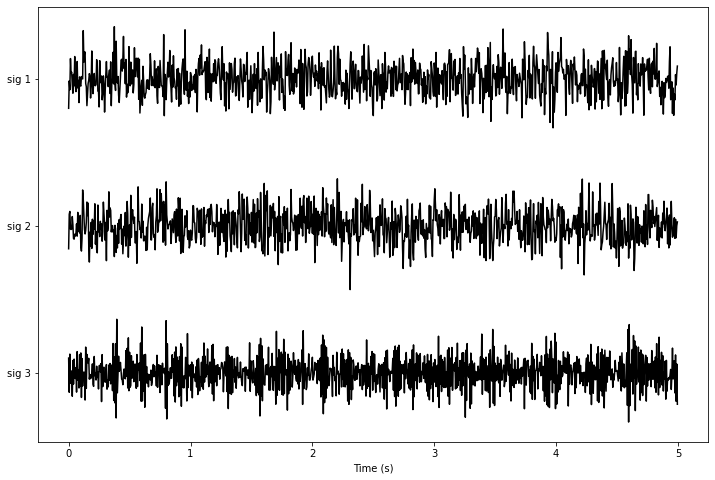

In [28]:
# Load signals
sig = np.loadtxt('sig_ex1.txt', delimiter=',')
t = np.arange(0.0, 5.0, 1/200)

# Plot EEG
plt.figure(figsize=(12, 8))
plot_EEG(t, sig)

### Correlation
Investigate the correlation between all pairs of signals. You can use the function [np.corrcoef(x,y)](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html) to calculate the correlation between x and y.

<div class="alert alert-info">

**Question:** What can you conclude about the correlation between the signals?

<div class="alert alert-success">
<span style="color:black">

**Answer:**

Insert your answer here...
    
</span>

In [10]:
sig_1 = sig[:, 0]
sig_2 = sig[:, 1]
sig_3 = sig[:, 2]

corrc_3sig = np.corrcoef([sig_1, sig_2, sig_3])

print(f"correlation 1-2: {round(corrc_3sig[0,1], 6)}\ncorrelation 1-3:  {round(corrc_3sig[0,2], 6)}\ncorrelation 2-3:  {round(corrc_3sig[1,2], 6)}")

correlation 1-2: -0.012183
correlation 1-3:  0.009815
correlation 2-3:  0.026697


### Cross-correlation
Calculate the cross-correlation between all pairs of signals and plot the result for lag values between [-10, 10] using a stem plot. Use the function [np.correlate(x,y)](https://numpy.org/doc/stable/reference/generated/numpy.correlate.html) to calculate the cross-correlation between the signals x and y.

<div class="alert alert-info">

**Question:** How do you interpret the cross-correlation results? Can you deduct a directional relationship between the signals?

<div class="alert alert-success">
<span style="color:black">

**Answer:**

Insert your answer here...
    
</span>

<ipython-input-24-2308a866dff2>:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(np.arange(-10, 10, 1),correl_12[middle-10:middle+10])


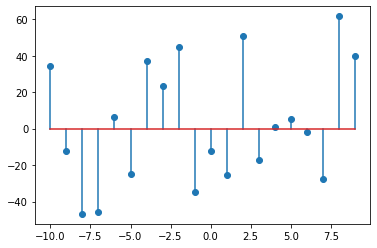

<ipython-input-24-2308a866dff2>:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(np.arange(-10, 10, 1),correl_13[middle-10:middle+10])


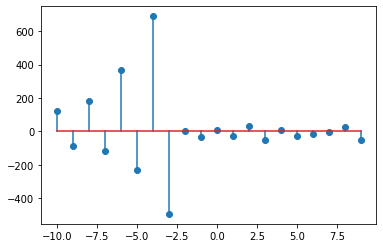

<ipython-input-24-2308a866dff2>:17: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(np.arange(-10, 10, 1),correl_23[middle-10:middle+10])


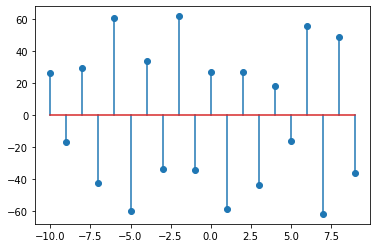

In [24]:
correl_12 = np.correlate(sig_1, sig_2, mode='full')
correl_13 = np.correlate(sig_1, sig_3, mode='full')
correl_23 = np.correlate(sig_2, sig_3, mode='full')

middle = len(correl_12) // 2

plt.stem(np.arange(-10, 10, 1),correl_12[middle-10:middle+10])
plt.show()

plt.stem(np.arange(-10, 10, 1),correl_13[middle-10:middle+10])
plt.show()

plt.stem(np.arange(-10, 10, 1),correl_23[middle-10:middle+10])
plt.show()

### Granger-causality index
Investigate the Granger causality index (GCI) between the signals. The function calculates the autoregressive model between the signals in the matrix sig with a model order equal to p. The autoregressive model is defined as follows, with A(m) the coefficients, E(n) the residuals and X(n) the signal:

$$ X(n) = \sum_{m=1}^{p} A(m)X(n-m) + E(n) $$

Study the GCI between the signals with model order p=5. You need to implement the GCI yourself based on the functions *AR_univariate* and *AR_bivariate* and the formula of the GCI from signal y to signal x:

$$ GCI_{xy} = ln\left(\frac{V_{x|x}}{V_{x|xy}}\right) $$

where $V_{x|x}$ is the variance of the residual in the univariate case and $V_{x|xy}$ is the variance of the residual in te bivariate model.

>*Note: The functions AR_univariate and AR_bivariate output two variables: A and res. A is a (p x K x K) matrix with the AR coefficients. res is the reflection matrix, which contains the standard deviation of the prediction errors.*

<div class="alert alert-info">

**Question:** What can you conclude about the connectivity pattern between the signals?
    
What happens if you decrease the model order to 2 or increase it to 10? Insert the corresponding GCI values in the table below.

<div class="alert alert-success">
<span style="color:black">

**Answer:**

Insert your answer here...
    
|               | p = 2| p = 5| p = 10|
|:-----------------|:-----------|:-----------|:------|
| $GCI_{1,1}$ |   |   |   |
| $GCI_{1,2}$ |   |   |   |
| $GCI_{1,3}$ |   |   |   |
| $GCI_{2,1}$ |   |   |   |
| $GCI_{2,2}$ |   |   |   |
| $GCI_{2,3}$ |   |   |   |
| $GCI_{3,1}$ |   |   |   |
| $GCI_{3,2}$ |   |   |   |
| $GCI_{3,3}$ |   |   |   |
    
</span>

In [29]:
# x = signal
# p = order of the model
# fs = sample frequency -> 200 Hz

def AR_univariate(x, p, fs):
    data = cp.Data(np.expand_dims(x, axis=0), fs)
    data.fit_mvar(p, 'yw')
    
    A = data.mvarcoef[0]
    res = data.mvarcoef[1]
    return A, res

def AR_bivariate(x, y, p, fs):
    data = np.vstack([x, y])
    data = cp.Data(data, fs)
    data.fit_mvar(p, 'yw')
    
    A = data.mvarcoef[0]
    res = data.mvarcoef[1]
    return A, res

In [46]:
def GCI(x, y, order, fs):
  variance_xx = (AR_univariate(x, order, fs)[1]) ** 2
  
  if (x == y).all(): # if it's the same signal, then return 0
    return 0
  else: # if it's not the same signal get the mean of the std matrix and square it to get the variance
    variance_xy = (AR_bivariate(x, y, order, fs)[1]).mean() ** 2

  return np.log(variance_xx / variance_xy)
  

GCI_sig1_sig1 = [GCI(sig_1, sig_1, 2, 200), GCI(sig_1, sig_1, 5, 200), GCI(sig_1, sig_1, 10, 200)]
GCI_sig1_sig2 = [GCI(sig_1, sig_2, 2, 200), GCI(sig_1, sig_2, 5, 200), GCI(sig_1, sig_2, 10, 200)]
GCI_sig1_sig3 = [GCI(sig_1, sig_3, 2, 200), GCI(sig_1, sig_3, 5, 200), GCI(sig_1, sig_3, 10, 200)]
GCI_sig2_sig1 = [GCI(sig_2, sig_1, 2, 200), GCI(sig_2, sig_1, 5, 200), GCI(sig_2, sig_1, 10, 200)]
GCI_sig2_sig2 = [GCI(sig_2, sig_2, 2, 200), GCI(sig_2, sig_2, 5, 200), GCI(sig_2, sig_2, 10, 200)]
GCI_sig2_sig3 = [GCI(sig_2, sig_3, 2, 200), GCI(sig_2, sig_3, 5, 200), GCI(sig_2, sig_3, 10, 200)]
GCI_sig3_sig1 = [GCI(sig_3, sig_1, 2, 200), GCI(sig_3, sig_1, 5, 200), GCI(sig_3, sig_1, 10, 200)]
GCI_sig3_sig2 = [GCI(sig_3, sig_2, 2, 200), GCI(sig_3, sig_2, 5, 200), GCI(sig_3, sig_2, 10, 200)]
GCI_sig3_sig3 = [GCI(sig_3, sig_3, 2, 200), GCI(sig_3, sig_3, 5, 200), GCI(sig_3, sig_3, 10, 200)]


print(f"\nGCI sig_1 sig_1 p=2: {GCI_sig1_sig1[0]}\nGCI sig_1 sig_1 p=5: {GCI_sig1_sig1[1]}\nGCI sig_1 sig_1 p=10: {GCI_sig1_sig1[2]}\n")
print(f"\nGCI sig_1 sig_2 p=2: {GCI_sig1_sig2[0]}\nGCI sig_1 sig_2 p=5: {GCI_sig1_sig2[1]}\nGCI sig_1 sig_2 p=10: {GCI_sig1_sig2[2]}\n")
print(f"\nGCI sig_1 sig_3 p=2: {GCI_sig1_sig3[0]}\nGCI sig_1 sig_3 p=5: {GCI_sig1_sig3[1]}\nGCI sig_1 sig_3 p=10: {GCI_sig1_sig3[2]}\n")
print(f"\nGCI sig_2 sig_1 p=2: {GCI_sig2_sig1[0]}\nGCI sig_2 sig_1 p=5: {GCI_sig2_sig1[1]}\nGCI sig_2 sig_1 p=10: {GCI_sig2_sig1[2]}\n")
print(f"\nGCI sig_2 sig_2 p=2: {GCI_sig2_sig2[0]}\nGCI sig_2 sig_2 p=5: {GCI_sig2_sig2[1]}\nGCI sig_2 sig_2 p=10: {GCI_sig2_sig2[2]}\n")
print(f"\nGCI sig_2 sig_3 p=2: {GCI_sig2_sig3[0]}\nGCI sig_2 sig_3 p=5: {GCI_sig2_sig3[1]}\nGCI sig_2 sig_3 p=10: {GCI_sig2_sig3[2]}\n")
print(f"\nGCI sig_3 sig_1 p=2: {GCI_sig3_sig1[0]}\nGCI sig_3 sig_1 p=5: {GCI_sig3_sig1[1]}\nGCI sig_3 sig_1 p=10: {GCI_sig3_sig1[2]}\n")
print(f"\nGCI sig_3 sig_2 p=2: {GCI_sig3_sig2[0]}\nGCI sig_3 sig_2 p=5: {GCI_sig3_sig2[1]}\nGCI sig_3 sig_2 p=10: {GCI_sig3_sig2[2]}\n")
print(f"\nGCI sig_3 sig_3 p=2: {GCI_sig3_sig3[0]}\nGCI sig_3 sig_3 p=5: {GCI_sig3_sig3[1]}\nGCI sig_3 sig_3 p=10: {GCI_sig3_sig3[2]}\n")


GCI sig_1 sig_1 p=2: 0
GCI sig_1 sig_1 p=5: 0
GCI sig_1 sig_1 p=10: 0


GCI sig_1 sig_2 p=2: [[1.41807828]]
GCI sig_1 sig_2 p=5: [[1.42695187]]
GCI sig_1 sig_2 p=10: [[1.42975353]]


GCI sig_1 sig_3 p=2: [[1.98447221]]
GCI sig_1 sig_3 p=5: [[2.77825908]]
GCI sig_1 sig_3 p=10: [[2.77612897]]


GCI sig_2 sig_1 p=2: [[1.41984831]]
GCI sig_2 sig_1 p=5: [[1.41834647]]
GCI sig_2 sig_1 p=10: [[1.43286382]]


GCI sig_2 sig_2 p=2: 0
GCI sig_2 sig_2 p=5: 0
GCI sig_2 sig_2 p=10: 0


GCI sig_2 sig_3 p=2: [[2.00341316]]
GCI sig_2 sig_3 p=5: [[2.00301844]]
GCI sig_2 sig_3 p=10: [[2.02036509]]


GCI sig_3 sig_1 p=2: [[0.59983499]]
GCI sig_3 sig_1 p=5: [[1.3896047]]
GCI sig_3 sig_1 p=10: [[1.39702395]]


GCI sig_3 sig_2 p=2: [[0.61700591]]
GCI sig_3 sig_2 p=5: [[0.62296946]]
GCI sig_3 sig_2 p=10: [[0.63814978]]


GCI sig_3 sig_3 p=2: 0
GCI sig_3 sig_3 p=5: 0
GCI sig_3 sig_3 p=10: 0



/usr/local/lib/python3.8/dist-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


***
## Part 2/2: Localization of the epileptic focus from intracranial EEG recordings
During the presurgical evaluation a patient was implanted with 2 depth electrodes, each with 12 contacts, into the amygdala and hippocampus. We consider only 4 electrode contacts from each depth electrode: 2 in the left and right amygdala (LA1-2 and RA1-2) and 2 contacts in the left and right hippocampus (LH1-2 and RH1-2). The signals of a recorded seizure can be found in sig_ex2.txt. The variable sig contains following signals: RH1, RH2, RA1, RA2, LH1, LH2, LA1, LA2. The intracranial EEG is recorded with a sampling frequency of 256 Hz. The variable sig contains 5s of seizure. Can you localize where the seizure originated from based on functional connectivity?

<img src='https://drive.google.com/uc?export=view&id=1EjYAnx4hpY-LgiHWNpH0cfd7ysCUJyBb' style="width: 500px;">


Again let's start with loading and plotting the measured time series.

<div class="alert alert-info">

**Question:** What do you notice in the signals?

<div class="alert alert-success">
<span style="color:black">

**Answer:**

Insert your answer here...
    
</span>

In [ ]:
sig = np.loadtxt('sig_ex2.txt', delimiter=',')
t = np.arange(0.0, 5.0, 1/256)
labels = ["RH1", "RH2", "RA1", "RA2", "LH1", "LH2", "LA1", "LA2"]

plt.figure(figsize=(12, 8))
plot_EEG(t, sig, labels=labels)

#### Coherence
Study the coherence between the signals. You can use the function [coherence(x,y,fs)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.coherence.html) to calculate the coherence between the signals x and y. Make a matrix COH in which the coherence values of all pairwise combination of channels are stored. COH has the following dimensions: K x K x frequency_point, with K the number of signals (in our case K=8). Use the function plot_COH(COH, freq, labels) to visualize the coherence.

<div class="alert alert-info">

**Question:** What can you observe?

<div class="alert alert-success">
<span style="color:black">

**Answer:**

Insert your answer here...
    
</span>

In [ ]:
def plot_COH(COH, freq, labels):
    n_sig = np.shape(COH)[0]
    
    fig, axs = plt.subplots(n_sig, n_sig, sharex='col', sharey='row', figsize=(15, 15))
    for i in range(n_sig):
        for j in range(n_sig):
            axs[i,j].fill_between(freq, COH[i,j,:])
            axs[i,j].set_title('{} -> {}'.format(labels[i], labels[j]))

#### Directed Transfer Function
Implement the Directed Transfer Function (DTF) based on the coefficients that you can obtain with the function AutoReg. The coefficient matrix (A) has dimensions K x K x p and is ordered as follows: [from (i), to (j), m=1..p]. Implement the DTF so it has following dimensions [K (from which channel), K (to which channel), nr_frequency_points] with K being the number of signals (in our case K=8). You can use p equal to 10. The implementation can be done as follows:

1. Calculate the autoregressive coefficients based on the function AR_multivariate with order p=10.
2. Calculate for each frequency f=0:0.1:30, A(f) with dimensions equal to K x K x nr_frequency_points.
*Note: be sure to write j to obtain the imaginary number*
3. Invert the A(f) matrix to obtain H(f) at each frequency.
4. Calculate the DTF based on the H(f) matrix using the following formula:

$$ DTF_{ij} = \frac{|H_{ij}(f)|^2}{\sum_{k=1}^{K}|H_{ik}(f)|^2}$$

In this equation, $H_{ij}$ is the information flow from j to i by definition.

What do you obseve? You can use the function plot_DTF(DTF, freq, labels) to visualize the result of the DTF. Which region is the generator of the seizure?

<div class="alert alert-info">

**Question:** What do you observe? You can use the function plot_DTF(DTF, freq, labels) to visualize the result of the DTF. Which region is the generator of the seizure?

<div class="alert alert-success">
<span style="color:black">

**Answer:**

Insert your answer here...
    
</span>

In [ ]:
def AR_multivariate(x, p, fs):
    data = np.transpose(x)
    data = cp.Data(data, fs)
    data.fit_mvar(p, 'yw')
    
    A = data.mvarcoef[0]
    res = data.mvarcoef[1]
    return A, res